# Modelar una serie de tiempo con MLP

Este cuaderno replica el contenido del documento fuente, convirtiendo su texto en **Markdown** y sus bloques de código en **celdas ejecutables**. 
Se **ignoran imágenes y salidas (parsed-literal)** como se solicitó.


## Carga de datos

Trabajaremos con un conjunto de datos de clima global para predecir la **temperatura promedio diaria en Nueva York** utilizando un modelo **Perceptrón Multicapa (MLP)**.


In [1]:
import pandas as pd

# Leer el archivo CSV (ajusta la ruta a tu entorno)
file_path = "global_weather_data_2015_2024.csv"
data = pd.read_csv(file_path, encoding='latin1')

# Filtrar USA y ciudad de New York
usa_data = data[data['country'] == 'USA']
new_york_data = usa_data[usa_data['city'] == 'New York']

# Indexar por fecha y seleccionar la columna objetivo
new_york_data.set_index('date', inplace=True)
new_york_tavg = new_york_data['tavg']

print("Columnas:", data.columns.tolist())
print("Primeros registros de la serie objetivo:")
print(new_york_tavg.head())

Columnas: ['date', 'tavg', 'tmin', 'tmax', 'prcp', 'snow', 'wdir', 'wspd', 'wpgt', 'pres', 'tsun', 'city', 'country']
Primeros registros de la serie objetivo:
date
2015-01-02 00:00:00    2.6
2015-01-03 00:00:00    0.9
2015-01-04 00:00:00    6.6
2015-01-05 00:00:00    5.4
2015-01-06 00:00:00   -6.4
Name: tavg, dtype: float64


## Preprocesamiento

### Extracción de características (ventanas temporales)

Creamos ventanas deslizantes de longitud `window_size` sobre la serie para construir el conjunto de entrenamiento:

- **Ventana de entrada (X):** contiene `window_size` valores consecutivos de la serie.
- **Valor objetivo (y):** el siguiente valor en la serie inmediatamente después de la ventana.

**Sin fuga de datos:** El valor objetivo está fuera de la ventana y corresponde a un punto en el futuro.


In [2]:
import numpy as np

def create_time_windows(series, window_size):
    X, y = [], []
    for i in range(len(series) - window_size):
        X.append(series.iloc[i:i + window_size].values)  # Acceso por posición
        y.append(series.iloc[i + window_size])           # Objetivo fuera de la ventana
    return np.array(X), np.array(y)

# Crear ventanas de 7 días (puedes ajustar esta longitud)
WINDOW_SIZE = 7
X, y = create_time_windows(new_york_tavg, WINDOW_SIZE)

# Asegurar formas adecuadas
X = np.array(X)
y = np.array(y).flatten()  # y como vector 1D

print("Forma de X:", X.shape)
print("Forma de y:", y.shape)

Forma de X: (3642, 7)
Forma de y: (3642,)


### Escalar o normalizar la serie

**Recomendaciones prácticas para redes neuronales:**

- **Series financieras/ruidosas:** `RobustScaler` o `StandardScaler`  
- **Series con crecimiento o escala amplia:** `Log` + `MinMaxScaler`  
- **LSTM/GRU/CNN:** mantener datos en rango `[-1, 1]` ayuda a la convergencia

| Método              | Robustez a outliers | Mantiene orden temporal | Ideal para                      | Precauciones                      |
|--------------------|---------------------|-------------------------|----------------------------------|-----------------------------------|
| Min–Max            | ❌                  | ✅                      | Datos acotados, sin picos       | Sensible a extremos               |
| StandardScaler     | ⚠️                  | ✅                      | Series estables                  | Puede amplificar outliers         |
| RobustScaler       | ✅                  | ✅                      | Series financieras/ruidosas      | Reduce sensibilidad a cambios suaves |
| Log Transform      | ✅                  | ✅                      | Datos positivos con crecimiento  | No usar con valores negativos     |
| Power Transform    | ✅                  | ✅                      | Distribuciones sesgadas          | Requiere ajuste cuidadoso         |
| Incremental Scaling| ✅                  | ✅                      | Series en streaming              | Menor precisión si cambian estadísticas |
| Per-variable Scaling| ✅                 | ✅                      | Series multivariadas             | Aplicar coherentemente al predecir |


In [3]:
from sklearn.preprocessing import MinMaxScaler

# Dos escaladores separados para X e y
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# Ajustar y transformar X: reestructuramos a 2D para encajar y luego devolvemos a (n, window)
X_scaled = scaler_X.fit_transform(X.reshape(-1, X.shape[-1])).reshape(X.shape)

# Ajustar y transformar y al rango [0, 1]
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()

print("Ejemplo de X escalado (primeras 3 filas):")
print(X_scaled[:3])
print("Ejemplo de y escalado (primeros 5 valores):")
print(y_scaled[:5])

Ejemplo de X escalado (primeras 3 filas):
[[0.34051724 0.30387931 0.42672414 0.40086207 0.14655172 0.13146552
  0.04525862]
 [0.30387931 0.42672414 0.40086207 0.14655172 0.13146552 0.04525862
  0.17456897]
 [0.42672414 0.40086207 0.14655172 0.13146552 0.04525862 0.17456897
  0.14224138]]
Ejemplo de y escalado (primeros 5 valores):
[0.17456897 0.14224138 0.17456897 0.31681034 0.27155172]


## Construcción del modelo MLP

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
import tensorflow as tf

# Fijar semilla para reproducibilidad
tf.random.set_seed(42)

# Modelo sencillo MLP
model = Sequential([
    Input(shape=(X.shape[1],)),    # Número de rezagos (window_size)
    Dense(32, activation='relu'),  # Capa oculta
    Dense(1)                       # Predicción 1 paso adelante
])

model.compile(optimizer='adam', loss='mse', metrics=['mse'])
model.summary()

2025-10-27 18:36:57.094796: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
I0000 00:00:1761608221.560413   33087 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2527 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 289 (1.13 KB)

 Trainable params: 289 (1.13 KB)

 Non-trainable params: 0 (0.00 B)

## Entrenamiento

In [5]:
history = model.fit(
    X_scaled, y_scaled,
    epochs=500,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

Epoch 1/500


2025-10-27 18:37:03.767471: I external/local_xla/xla/service/service.cc:163] XLA service 0x7f40dc004ce0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-10-27 18:37:03.767486: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce GTX 1650, Compute Capability 7.5
2025-10-27 18:37:03.797497: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-10-27 18:37:04.002926: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91400


26/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0811 - mse: 0.0811

I0000 00:00:1761608224.776674   33196 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 0.0161 - mse: 0.0161 - val_loss: 0.0046 - val_mse: 0.0046
Epoch 2/500
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0059 - mse: 0.0059 - val_loss: 0.0043 - val_mse: 0.0043
Epoch 3/500
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0054 - mse: 0.0054 - val_loss: 0.0038 - val_mse: 0.0038
Epoch 4/500
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0050 - mse: 0.0050 - val_loss: 0.0037 - val_mse: 0.0037
Epoch 5/500
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0049 - mse: 0.0049 - val_loss: 0.0036 - val_mse: 0.0036
Epoch 6/500
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0048 - mse: 0.0048 - val_loss: 0.0036 - val_mse: 0.0036
Epoch 7/500
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0047 - mse: 0.0047 - val_loss: 0.0035 - val_mse: 0.0035
Epoch 8/500
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0047 - mse: 0.0047 - val_loss: 0.0035 - val_mse: 0.0035
Epoch 9/500
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0047 - mse: 0.

## Curvas de pérdida (entrenamiento vs validación)

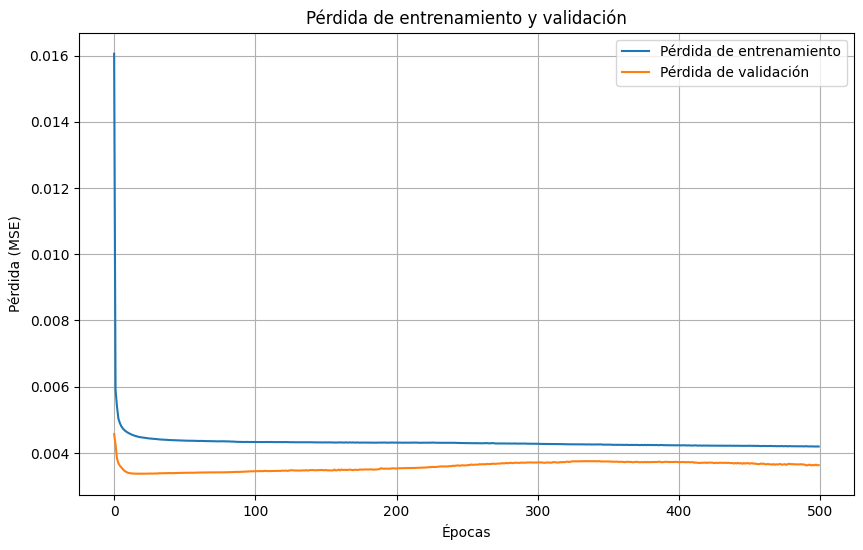

In [6]:
import matplotlib.pyplot as plt

train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Pérdida de entrenamiento')
plt.plot(val_loss, label='Pérdida de validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida (MSE)')
plt.title('Pérdida de entrenamiento y validación')
plt.legend()
plt.grid(True)
plt.show()

## Predicción e inversión de escala

In [7]:
# Predicciones sobre X_scaled
y_pred = model.predict(X_scaled)

# Invertir la escala de las predicciones y del objetivo para interpretar en unidades originales
y_pred_rescaled = scaler_y.inverse_transform(y_pred)

print("Predicciones (primeros 5 valores, escala original):")
print(y_pred_rescaled[:5].flatten())

114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Predicciones (primeros 5 valores, escala original):
[-7.5477686   0.98872685 -6.693269    2.619703    1.580389  ]


## Gráfico: valores reales vs predichos

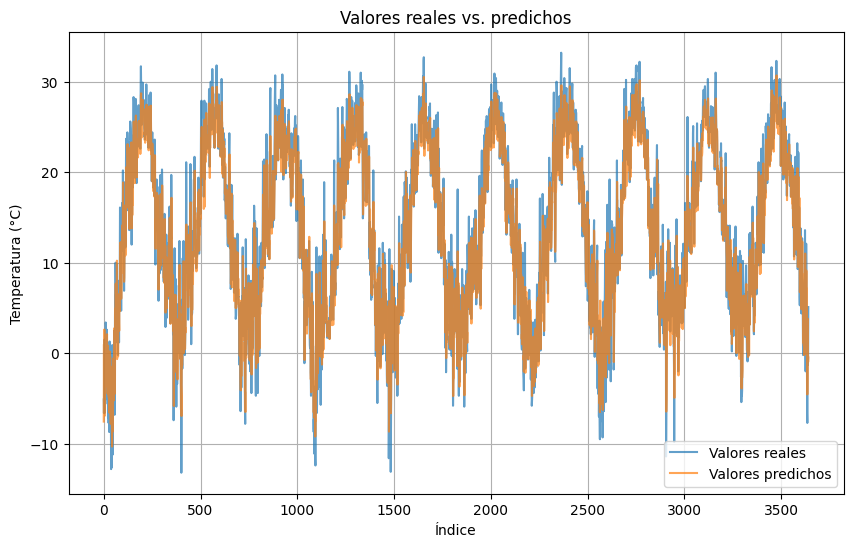

In [8]:
plt.figure(figsize=(10, 6))
plt.plot(y, label='Valores reales', alpha=0.7)
plt.plot(y_pred_rescaled, label='Valores predichos', alpha=0.7)
plt.xlabel('Índice')
plt.ylabel('Temperatura (°C)')
plt.title('Valores reales vs. predichos')
plt.legend()
plt.grid(True)
plt.show()

## Análisis de residuales

Forma de residuales: (3642,)


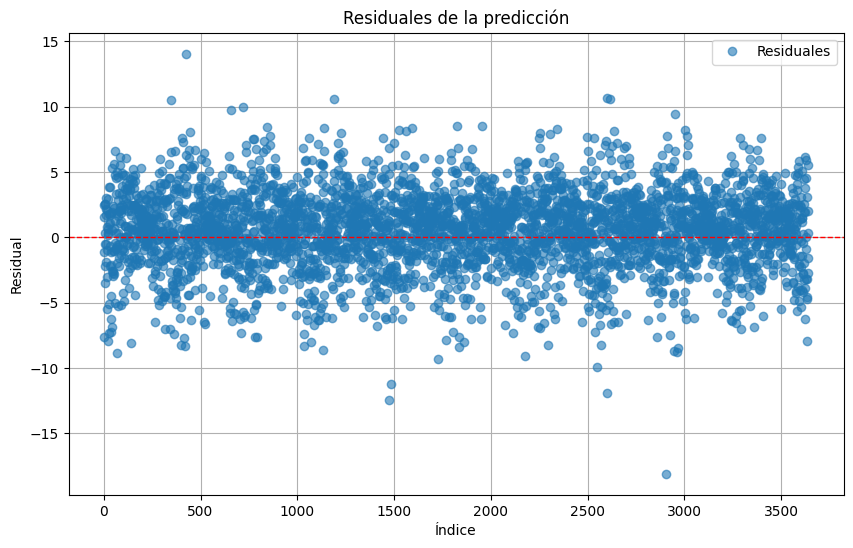

In [9]:
residuals = y - y_pred_rescaled.flatten()
print("Forma de residuales:", residuals.shape)

plt.figure(figsize=(10, 6))
plt.plot(residuals, label='Residuales', linestyle='', marker='o', alpha=0.6)
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.xlabel('Índice')
plt.ylabel('Residual')
plt.title('Residuales de la predicción')
plt.legend()
plt.grid(True)
plt.show()

## Optimización de hiperparámetros (borrador)

**Sugerencias de herramientas**

| Escenario                            | Herramientas sugeridas                                 |
|-------------------------------------|--------------------------------------------------------|
| Modelos clásicos (SVM, RF, XGB)     | GridSearchCV, RandomizedSearchCV, Optuna, HyperOpt     |
| Deep Learning (Keras/TensorFlow)    | Keras Tuner, Optuna, Ray Tune                          |
| Búsqueda escalable/distribuida      | Ray Tune, BOHB, Optuna + Ray                           |
| AutoML / pipelines automáticos      | TPOT, Auto-Sklearn, AutoKeras                          |
| Exploración evolutiva/heurística    | Nevergrad, DEAP, PyGAD                                 |


In [10]:
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.base import BaseEstimator, RegressorMixin
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam, SGD
import numpy as np

# Wrapper scikit-learn para un modelo Keras simple
class KerasRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, optimizer='adam', neurons=64, batch_size=32, epochs=10, verbose=0):
        self.optimizer = optimizer
        self.neurons = neurons
        self.batch_size = batch_size
        self.epochs = epochs
        self.verbose = verbose
        self.model = None

    def build_model(self):
        model = Sequential([
            Dense(self.neurons, activation='relu', input_shape=(X.shape[1],)),
            Dense(self.neurons // 2, activation='relu'),
            Dense(1)
        ])
        optimizer = Adam() if self.optimizer == 'adam' else SGD()
        model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
        return model

    def fit(self, X, y):
        self.model = self.build_model()
        self.model.fit(X, y, batch_size=self.batch_size, epochs=self.epochs, verbose=self.verbose)
        return self

    def predict(self, X):
        return self.model.predict(X, verbose=0).flatten()

print("Wrapper KerasRegressor definido.")

Wrapper KerasRegressor definido.


In [11]:
# Definir hiperparámetros a explorar (ejemplo pequeño)
param_grid = {
    'optimizer': ['adam', 'sgd'],
    'neurons': [32, 64],
    'batch_size': [16],
    'epochs': [10]
}

# Validación cruzada para series temporales
cv = TimeSeriesSplit(n_splits=3)

# Configurar GridSearchCV
grid = GridSearchCV(estimator=KerasRegressor(verbose=0),
                    param_grid=param_grid,
                    cv=cv,
                    scoring='neg_mean_squared_error',
                    verbose=0)

# Nota: Ejecutar el ajuste puede ser costoso en tiempo
# grid_result = grid.fit(X_scaled, y_scaled)
# print(f"Mejores parámetros: {grid_result.best_params_}")
# print(f"Mejor puntaje (MSE): {-grid_result.best_score_}")